# AE Compressor

The goal is to utilize an AutoEncoder model as an image compressor for being able to extract the code of various images. The code represents the meaningful features. Additionally, this will result in small image sizes with the capability of reconstructing the origin image to a certain degree.

Compression:

$$ compressed\%\ = 100 {units \over wh} $$

E.g. we can compress an image of 28x28 to 8.16% using a Dense layer with 64 units. We can even go further to 0.51% with 4 units and reconstruct a meaningful representation of an image.


In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

We will load the MNIST data set as example and normalize the pixel distribution

In [2]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

# normalize pixel distribution
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

In [3]:
num_values = x_train[0].shape[0] * x_train[0].shape[1]

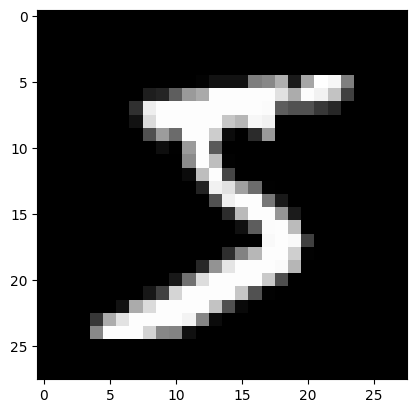

In [4]:
plt.imshow(x_train[0], cmap="gray");

Define the Encoder

In [5]:
compress_units = 64

encoder_input = keras.Input(shape=(28, 28, 1), name='encoder_input')
x = keras.layers.Flatten()(encoder_input)
encoder_output = keras.layers.Dense(compress_units, activation="relu")(x)
encoder = keras.Model(encoder_input, encoder_output, name='model_encoder')

Metal device set to: Apple M1 Pro


2022-10-20 22:04:29.725371: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-20 22:04:29.725563: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
print(f'Compressed to {round(100*(compress_units/num_values), 2)}%')

Compressed to 8.16%


Define the Decoder

In [7]:
decoder_input = keras.layers.Dense(compress_units, activation="relu")(encoder_output)
x = keras.layers.Dense(784, activation="relu")(decoder_input)
decoder_output = keras.layers.Reshape((28, 28, 1))(x)
decoder = keras.Model(decoder_input, decoder_output, name='model_decoder')

In [8]:
autoencoder_input = keras.Input(shape=(28, 28, 1), name="ae_input")
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)

autoencoder = keras.Model(autoencoder_input, decoded, name='model_autoencoder')

In [10]:
autoencoder.summary()

Model: "model_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ae_input (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 model_encoder (Functional)  (None, 64)                50240     
                                                                 
 model_decoder (Functional)  (None, 28, 28, 1)         50960     
                                                                 
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


In [11]:
optimizer = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
autoencoder.compile(optimizer, loss='mse')

/opt/homebrew/Caskroom/miniforge/base/envs/visAutoEncoder/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
epochs=3

for epoch in range(epochs):
    history = autoencoder.fit(x_train, x_train, epochs=1, batch_size=32, validation_split=0.10)
    # autoencoder.save(f"../models/ModelAutoEncoder-{epoch+1}.model")

2022-10-20 22:05:44.505892: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-20 22:05:44.636394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1688/1688 [==============================] - ETA: 0s - loss: 0.0172

2022-10-20 22:05:51.689437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1688/1688 [==============================] - 7s 4ms/step - loss: 0.0103 - val_loss: 0.0102


We will test the result by using one record from the test data

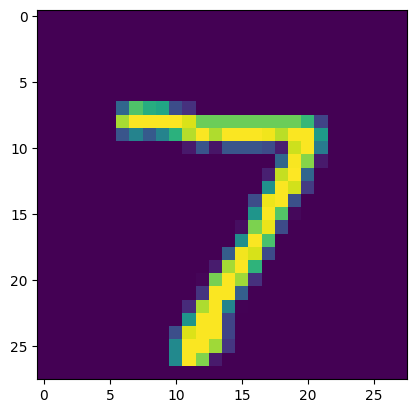

In [26]:
plt.imshow(x_test[0]);

1/1 [==============================] - 0s 38ms/step


2022-10-20 22:06:17.868349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


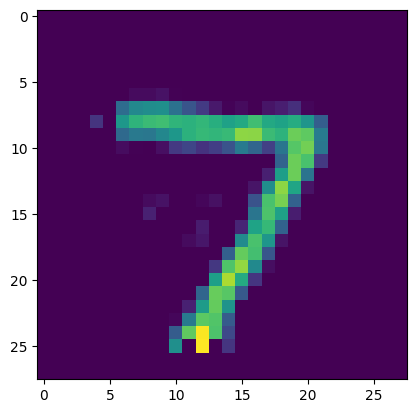

In [14]:
ae_out = autoencoder.predict([x_test[0].reshape(-1, 28, 28, 1) ])
plt.imshow(ae_out[0]);

Apply Encoder for extracting the code then using the code (extracted features) for reconstructing the origin image.

1/1 [==============================] - 0s 10ms/step


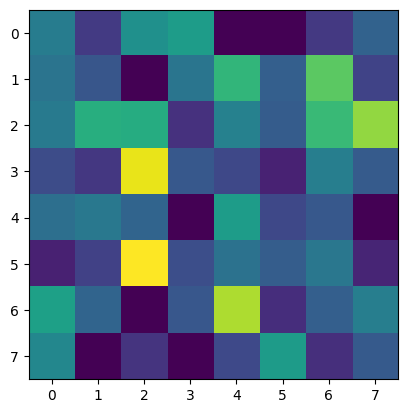

In [17]:
code_data = encoder.predict([x_test[0].reshape(-1, 28, 28, 1) ])
plt.imshow(code_data[0].reshape((8,8)));

Given the code, reconstruct the image with the trained decoder

In [18]:
decoded_code_data = decoder.predict([code_data[0].reshape(-1, 64)])

1/1 [==============================] - 0s 10ms/step


As the result shows, after reconstructing the given code of number 7 we get the image of number 7

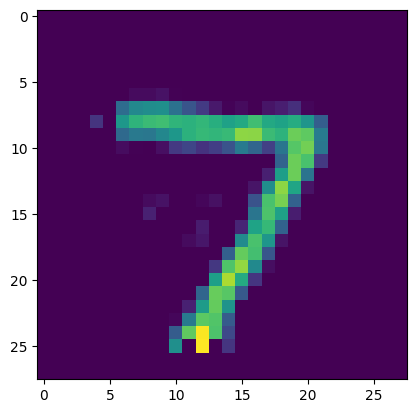

In [19]:
plt.imshow(decoded_code_data[0]);

In [22]:
print(f'We went from 28x28 -> 8x8 then 8x8 -> 28x28, with a code that represents {round(100*(compress_units/num_values), 2)}% information with just few epochs')

We went from 28x28 -> 8x8 then 8x8 -> 28x28, with a code that represents 8.16% information with just few epochs
